# Tuning the Hyperparameters

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import SymLogNorm, LogNorm
from astropy import units as u
from skimage import measure
from imutils import contours
import imutils
from astropy.table import Table
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve as ap_convolve
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '/Users/gianlucadituccio/Documents/Project'
data_path = path + '/data'

### 1. Uploading the dataset

The dataset is composed of 360 images (120 with 1 source, 120 without sources, 120 with 2 sources).
Besides, the "generate_sources.ipynb" creates also a table ("coordinates.csv") where for each image are saved the coordinates of the sources and the respective class:
- 0 for an image without sources;
- 1 for an image with a single source;
- 2 for an image with multiple sources.

In [4]:
coordinates_dataset = pd.read_csv('coordinates.csv') 
number_of_elements = coordinates_dataset.shape[0] # take the number of rows
 
# upload the path for the fits model, where the data values of the image are saved
base_url = data_path + '/model_sky{0:1d}.fits'

# create a list of FITS images
image_list = [base_url.format(n) for n in range(1, number_of_elements+1)]
image_concat = [fits.open(image) for image in image_list]

### 2. Splitting the dataset into training and test set

To tune the hyperparameters of the algorithm and to evaluate it, the program divides the dataset into training and test set.

In [5]:
from sklearn.model_selection import train_test_split
seed = 42
train_size = 0.7
X = coordinates_dataset.drop(["Class"], axis=1)
y = coordinates_dataset["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size = train_size, stratify=y)

In [6]:
# this is for having an overview of the dataset of coordinates and classes
print(coordinates_dataset)

     Coordinate 1  Coordinate 2  Class
0         83.4261       24.4038      1
1         81.2923       21.4266      1
2         85.9421       23.3361      1
3         81.7750       21.7564      1
4         85.5318       22.2183      1
..            ...           ...    ...
355           NaN           NaN      2
356           NaN           NaN      2
357           NaN           NaN      2
358           NaN           NaN      2
359           NaN           NaN      2

[360 rows x 3 columns]


In [7]:
print(X_train)

     Coordinate 1  Coordinate 2
245           NaN           NaN
158           NaN           NaN
359           NaN           NaN
110       85.9014       22.0702
315           NaN           NaN
..            ...           ...
128           NaN           NaN
127           NaN           NaN
136           NaN           NaN
318           NaN           NaN
314           NaN           NaN

[251 rows x 2 columns]


In [8]:
print(y_train)

245    2
158    0
359    2
110    1
315    2
      ..
128    0
127    0
136    0
318    2
314    2
Name: Class, Length: 251, dtype: int64


### 3. Functions for processing images

In [9]:
# here there is the function used for applying the gaussian filter
def gaussian_filtering(image):
    sigma = 4
    gauss_kernel = Gaussian2DKernel(sigma, x_size=(2*3*sigma+1), y_size=(2*3*sigma+1))
    return ap_convolve(image, gauss_kernel, normalize_kernel=True)

In [10]:
# here there is the function used for applying the linear_mapping,
# from a float64 to an uint8 (range from 0 to 255)
def linear_mapping(image):
    # f --> float64
    # u --> uint8
    f_max = np.amax(image)
    f_min = np.amin(image)
    u_min = 0
    u_max = 255
    # u = (u_max - u_min) / (f_max - f_min) * (f - f_min) + u_min
    x, y = image.shape
    for i in range(0,x):
        for j in range(0,y):
            image[i,j] = ((u_max - u_min) / (f_max - f_min)) * (image[i,j] - f_min) + u_min
    linear_mapping_image = np.round(image, 0)
    return np.uint8(linear_mapping_image)

In [11]:
# here there is the function used for applying the threshold.
# for thresholding the image we need to find the better parameter --> 
# we use hyperparameters on the value of the median.
def thresholding_image(image, median_factor):
    return np.where(image >= np.median(image)*median_factor, 255, 0)

### 4. Tuning the hyperparameters

The algorithm evaluates images with two hyperparameters:
- number of pixel for taking a valid label, with a range from 3 to 14;
- median with a range from 2.3 and 3.3;

In [12]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import math 

error_max = 0.1  # the max degrees error for the coordinates
X_train_models_selected = X_train.index.values  # it's the index of models that X_train has choosen

# then the algorithm creates a dateset where saving the best pairs of hyperparameters and their F1
recap_parameter = pd.DataFrame(columns = ['Median Factor', 'N. Pixel', 'F1 Score Macro', 'N. Models Exceed Max Error'])  


for median_factor in np.arange(2.3, 3.3, 0.1):
    
    # the range for tunining the hyperparameter "number of pixel", from 4 to 13
    for n_pixel in range(3, 14):
        
        # save the number of the models and their max error,
        # when the predicted coordinates exceed the true coordinates with more than error_max
        model_exceed_max_error = pd.DataFrame(columns = ['Model n.', 'Max Error']) 
        
        y_class_predicted = []  # it's the list for the predicted class
        
        for i in X_train_models_selected:
            wcs = WCS(image_concat[i][0].header)
            
            # from the collection of image, choose the right image that X_train has choosen and then
            # it extracts the data values from the image (a numpy with float64 elements)
            image_selected = image_concat[i][0].data

            # apply gaussian 
            gaussian_image = gaussian_filtering(image_selected)

            # apply stretch
            linear_mapping_image = linear_mapping(gaussian_image)
            
            # apply threshold
            threshold_image = thresholding_image(linear_mapping_image, median_factor)
            
            # take the coordinates of the actual model
            true_coordinates = list(coordinates_dataset.iloc[i])
            
            # if there aren't sources, the image has a 0 class, otherwise continue
            if not np.all(threshold_image==0):

                # labelling and blob of the threshold image
                # labels = a mask where applying labelling
                labels = measure.label(threshold_image, background=0)
                
                mask = np.zeros(threshold_image.shape, dtype="uint8")
                
                unique, counts = np.unique(labels, return_counts=True)
                # print(unique,counts)
                # unique --> it saves the unique classes of the labels
                # counts --> it counts how many pixels there are for each label
                # for example unique: [0 1] , counts: [249852    148]
                
                # take all the unique labels and go on
                for label in unique:     
                    # if it is the label 0 (background), do nothing and go on
                    if label == 0:
                        continue
                    
                    # create a label mask where storing only the actual label
                    labelMask = np.zeros(threshold_image.shape, dtype="uint8")
                    labelMask[labels == label] = 255
                    numPixels = cv2.countNonZero(labelMask)
                    
                    # ***** hyperparameter ******
                    # if the number of pixel of this label exceed the hyperparameter, store the previous label mask
                    # into the total mask
                    if numPixels >= n_pixel:
                        mask = cv2.add(mask, labelMask)

                # if in the mask there is at least a label
                if not np.all(mask == 0):
                    # find the contours
                    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
                    cnts = imutils.grab_contours(cnts)
                    cnts = contours.sort_contours(cnts)[0]
                    
                    # if there are more than two label (exclude background), the image has more than two sources
                    # It's a class 2
                    if len(cnts) >= 2:
                        y_class_predicted.append(2)

                    else:
                        # loop over the pixels contours of each label
                        for (p, c) in enumerate(cnts):
                            # use enclosing circle
                            ((cX, cY), radius) = cv2.minEnclosingCircle(c)
                            
                            # from pixel coordinates to degrees coordinates
                            x_predicted_coordinate_degree, y_predicted_coordinate_degree = wcs.wcs_pix2world(cX, cY, 1)
                            
                            if max(abs(true_coordinates[0]-x_predicted_coordinate_degree), 
                                        abs(true_coordinates[1]-y_predicted_coordinate_degree)) <= error_max:
                                y_class_predicted.append(1)
                            
                            # here we assume that there is only one label.
                            # if the true coordinates is NaN, then the true image has 2 sources.
                            # the predicted image has only one source, instead of two.
                            elif math.isnan(true_coordinates[0]):
                                y_class_predicted.append(1)
                            
                            # otherwise the coordinates error exceed the max error
                            else:
                                y_class_predicted.append(1)
                                _error = max(abs(true_coordinates[0]-x_predicted_coordinate_degree), abs(true_coordinates[1]-y_predicted_coordinate_degree))
                                model_exceed_max_error = model_exceed_max_error.append({'Model n.': i+1, 'Max Error': _error}, ignore_index = True)
                
                # if the image has labels fewer than the number of pixels, the image can be considered as background
                else:
                    y_class_predicted.append(0)

            else:
                y_class_predicted.append(0)


        # F1 score
        f1_train = np.round(f1_score(np.uint8(y_train), np.uint8(y_class_predicted), average = 'macro'),2)
        percentage = np.round((120-model_exceed_max_error.shape[0])/120*100, 2)
        
        # print the models in which the coordinates exceed the error max
        if not model_exceed_max_error.shape[0] == 0:
            print(model_exceed_max_error)
        
        # it saves only the pair of hyperparameters that have a F1 score > 0.7
        if f1_train > 0.7:
            recap_parameter = recap_parameter.append({'Median Factor': median_factor, 'N. Pixel': n_pixel, 
                                                      'F1 Score Macro': f1_train, 
                                                      'N. Models Exceed Max Error':model_exceed_max_error.shape[0]}, ignore_index = True)
        target_names = ['Class 0 [No Sources]', 'Class 1 [One Sources]', 'Class 2 [Multiple Sources]']
        print(classification_report(np.uint8(y_train), np.uint8(y_class_predicted), target_names=target_names))
        print("The percentage of images in which the coordinates don't exceed the error max is: {:4}%".format(percentage))
        print("Median Factor: {:4}, N. Pixel: {:3}".format(np.round(median_factor, 1), np.round(n_pixel,0)))
        
        print("================================================================================================")

                            precision    recall  f1-score   support

      Class 0 [No Sources]       1.00      0.08      0.15        84
     Class 1 [One Sources]       0.40      0.07      0.12        84
Class 2 [Multiple Sources]       0.36      0.99      0.53        83

                  accuracy                           0.38       251
                 macro avg       0.59      0.38      0.27       251
              weighted avg       0.59      0.38      0.27       251

The percentage of images in which the coordinates don't exceed the error max is: 100.0%
Median Factor:  2.3, N. Pixel:   3
                            precision    recall  f1-score   support

      Class 0 [No Sources]       1.00      0.10      0.17        84
     Class 1 [One Sources]       0.50      0.10      0.16        84
Class 2 [Multiple Sources]       0.36      0.99      0.53        83

                  accuracy                           0.39       251
                 macro avg       0.62      0.39      0.2

                            precision    recall  f1-score   support

      Class 0 [No Sources]       1.00      0.18      0.30        84
     Class 1 [One Sources]       0.42      0.18      0.25        84
Class 2 [Multiple Sources]       0.41      0.98      0.57        83

                  accuracy                           0.44       251
                 macro avg       0.61      0.44      0.38       251
              weighted avg       0.61      0.44      0.37       251

The percentage of images in which the coordinates don't exceed the error max is: 100.0%
Median Factor:  2.4, N. Pixel:   4
                            precision    recall  f1-score   support

      Class 0 [No Sources]       1.00      0.20      0.34        84
     Class 1 [One Sources]       0.45      0.21      0.29        84
Class 2 [Multiple Sources]       0.42      0.98      0.58        83

                  accuracy                           0.46       251
                 macro avg       0.62      0.46      0.4

                            precision    recall  f1-score   support

      Class 0 [No Sources]       1.00      0.43      0.60        84
     Class 1 [One Sources]       0.52      0.38      0.44        84
Class 2 [Multiple Sources]       0.53      0.98      0.69        83

                  accuracy                           0.59       251
                 macro avg       0.68      0.60      0.57       251
              weighted avg       0.68      0.59      0.57       251

The percentage of images in which the coordinates don't exceed the error max is: 100.0%
Median Factor:  2.5, N. Pixel:   5
                            precision    recall  f1-score   support

      Class 0 [No Sources]       1.00      0.44      0.61        84
     Class 1 [One Sources]       0.53      0.39      0.45        84
Class 2 [Multiple Sources]       0.53      0.98      0.69        83

                  accuracy                           0.60       251
                 macro avg       0.69      0.60      0.5

   Model n.  Max Error
0      19.0    0.10303
                            precision    recall  f1-score   support

      Class 0 [No Sources]       1.00      0.71      0.83        84
     Class 1 [One Sources]       0.72      0.65      0.69        84
Class 2 [Multiple Sources]       0.70      0.96      0.81        83

                  accuracy                           0.78       251
                 macro avg       0.81      0.78      0.78       251
              weighted avg       0.81      0.78      0.78       251

The percentage of images in which the coordinates don't exceed the error max is: 99.17%
Median Factor:  2.6, N. Pixel:   6
   Model n.  Max Error
0      19.0    0.10303
                            precision    recall  f1-score   support

      Class 0 [No Sources]       1.00      0.71      0.83        84
     Class 1 [One Sources]       0.73      0.67      0.70        84
Class 2 [Multiple Sources]       0.70      0.96      0.81        83

                  accuracy      

   Model n.  Max Error
0      19.0    0.10303
                            precision    recall  f1-score   support

      Class 0 [No Sources]       1.00      0.79      0.88        84
     Class 1 [One Sources]       0.79      0.79      0.79        84
Class 2 [Multiple Sources]       0.77      0.94      0.85        83

                  accuracy                           0.84       251
                 macro avg       0.85      0.84      0.84       251
              weighted avg       0.85      0.84      0.84       251

The percentage of images in which the coordinates don't exceed the error max is: 99.17%
Median Factor:  2.7, N. Pixel:   6
   Model n.  Max Error
0      19.0    0.10303
                            precision    recall  f1-score   support

      Class 0 [No Sources]       1.00      0.80      0.89        84
     Class 1 [One Sources]       0.80      0.81      0.80        84
Class 2 [Multiple Sources]       0.79      0.94      0.86        83

                  accuracy      

                            precision    recall  f1-score   support

      Class 0 [No Sources]       0.97      0.90      0.94        84
     Class 1 [One Sources]       0.85      0.92      0.88        84
Class 2 [Multiple Sources]       0.93      0.92      0.92        83

                  accuracy                           0.91       251
                 macro avg       0.92      0.91      0.91       251
              weighted avg       0.92      0.91      0.91       251

The percentage of images in which the coordinates don't exceed the error max is: 100.0%
Median Factor:  2.8, N. Pixel:   7
                            precision    recall  f1-score   support

      Class 0 [No Sources]       0.97      0.90      0.94        84
     Class 1 [One Sources]       0.85      0.92      0.88        84
Class 2 [Multiple Sources]       0.93      0.92      0.92        83

                  accuracy                           0.91       251
                 macro avg       0.92      0.91      0.9

                            precision    recall  f1-score   support

      Class 0 [No Sources]       0.98      0.98      0.98        84
     Class 1 [One Sources]       0.89      0.96      0.93        84
Class 2 [Multiple Sources]       0.99      0.90      0.94        83

                  accuracy                           0.95       251
                 macro avg       0.95      0.95      0.95       251
              weighted avg       0.95      0.95      0.95       251

The percentage of images in which the coordinates don't exceed the error max is: 100.0%
Median Factor:  2.9, N. Pixel:   8
                            precision    recall  f1-score   support

      Class 0 [No Sources]       0.98      0.98      0.98        84
     Class 1 [One Sources]       0.89      0.96      0.93        84
Class 2 [Multiple Sources]       0.99      0.90      0.94        83

                  accuracy                           0.95       251
                 macro avg       0.95      0.95      0.9

                            precision    recall  f1-score   support

      Class 0 [No Sources]       0.97      1.00      0.98        84
     Class 1 [One Sources]       0.90      0.95      0.92        84
Class 2 [Multiple Sources]       0.99      0.89      0.94        83

                  accuracy                           0.95       251
                 macro avg       0.95      0.95      0.95       251
              weighted avg       0.95      0.95      0.95       251

The percentage of images in which the coordinates don't exceed the error max is: 100.0%
Median Factor:  3.0, N. Pixel:   9
                            precision    recall  f1-score   support

      Class 0 [No Sources]       0.97      1.00      0.98        84
     Class 1 [One Sources]       0.90      0.95      0.92        84
Class 2 [Multiple Sources]       0.99      0.89      0.94        83

                  accuracy                           0.95       251
                 macro avg       0.95      0.95      0.9

                            precision    recall  f1-score   support

      Class 0 [No Sources]       0.97      1.00      0.98        84
     Class 1 [One Sources]       0.88      0.96      0.92        84
Class 2 [Multiple Sources]       1.00      0.87      0.93        83

                  accuracy                           0.94       251
                 macro avg       0.95      0.94      0.94       251
              weighted avg       0.95      0.94      0.94       251

The percentage of images in which the coordinates don't exceed the error max is: 100.0%
Median Factor:  3.1, N. Pixel:  10
                            precision    recall  f1-score   support

      Class 0 [No Sources]       0.97      1.00      0.98        84
     Class 1 [One Sources]       0.88      0.96      0.92        84
Class 2 [Multiple Sources]       1.00      0.87      0.93        83

                  accuracy                           0.94       251
                 macro avg       0.95      0.94      0.9

                            precision    recall  f1-score   support

      Class 0 [No Sources]       0.93      1.00      0.97        84
     Class 1 [One Sources]       0.84      0.93      0.88        84
Class 2 [Multiple Sources]       1.00      0.82      0.90        83

                  accuracy                           0.92       251
                 macro avg       0.92      0.92      0.92       251
              weighted avg       0.92      0.92      0.92       251

The percentage of images in which the coordinates don't exceed the error max is: 100.0%
Median Factor:  3.2, N. Pixel:  11
                            precision    recall  f1-score   support

      Class 0 [No Sources]       0.93      1.00      0.97        84
     Class 1 [One Sources]       0.84      0.93      0.88        84
Class 2 [Multiple Sources]       1.00      0.82      0.90        83

                  accuracy                           0.92       251
                 macro avg       0.92      0.92      0.9

In [13]:
# print the F1 score for each pair of hyperparameters
recap_parameter

,Median Factor,N. Pixel,F1 Score Macro,N. Models Exceed Max Error
0,2.5,12.0,0.71,1.0
1,2.5,13.0,0.73,1.0
2,2.6,3.0,0.75,1.0
3,2.6,4.0,0.76,1.0
4,2.6,5.0,0.77,1.0
...,...,...,...,...
74,3.2,9.0,0.92,0.0
75,3.2,10.0,0.92,0.0
76,3.2,11.0,0.92,0.0
77,3.2,12.0,0.92,0.0


### 5. Take the best hyperparameters

In [14]:
# take the pair with the highest F1 score
recap_parameter_best = recap_parameter[recap_parameter["F1 Score Macro"] == max(recap_parameter["F1 Score Macro"])]
optimal_n_pixel = np.round(recap_parameter_best.iloc[0][1], 3)
optimal_median_factor = np.round(recap_parameter_best.iloc[0][0], 2)

print("The best hyperparamiters are:")
print("N. Pixel --> " + str(optimal_n_pixel))
print("Median --> " + str(optimal_median_factor))
print("F1 score --> " + str(max(recap_parameter["F1 Score Macro"])))

The best hyperparamiters are:
N. Pixel --> 10.0
Median --> 2.9
F1 score --> 0.96


### 6. Evaluate the best hyperparameters on the test set

In [18]:
from sklearn.metrics import accuracy_score

# now the algorithm is applied to the test set
y_test_models_selected = y_test.index.values  # it's the index of models that X_train has choosen
y_test_predicted = []
model_exceed_max_error = pd.DataFrame(columns = ['Model n.', 'Max Error']) 

for i in y_test_models_selected:
    
    true_coordinates = list(coordinates_dataset.iloc[i])
    wcs = WCS(image_concat[i][0].header) # get the degrees range of the image
    
    # apply gaussian
    gaussian_image = gaussian_filtering(image_concat[i][0].data)
    
    # apply mapping
    linear_mapping_image = linear_mapping(gaussian_image)
    
    # apply threshold
    threshold_image = thresholding_image(linear_mapping_image, optimal_median_factor)
    
    if not np.all(threshold_image==0):
        
        # final step: labelling and blob
        labels = measure.label(threshold_image, background=0)
        mask = np.zeros(threshold_image.shape, dtype="uint8")
        unique, counts = np.unique(labels, return_counts=True)
        
        for label in unique:
            # applying labelling
            if label == 0:
                continue
            labelMask = np.zeros(threshold_image.shape, dtype="uint8")
            labelMask[labels == label] = 255
            numPixels = cv2.countNonZero(labelMask)
            if numPixels >= optimal_n_pixel:
                mask = cv2.add(mask, labelMask)
        
        
        if not np.all(mask == 0):
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            cnts = contours.sort_contours(cnts)[0]
            if len(cnts) >= 2:
                y_test_predicted.append(2)
            
            else:
                for (p, c) in enumerate(cnts):
                    (x, y, w, h) = cv2.boundingRect(c)
                    ((cX, cY), radius) = cv2.minEnclosingCircle(c)
                    
                    x_predicted_coordinate_degree, y_predicted_coordinate_degree = wcs.wcs_pix2world(cX, cY, 1)
                    if max(abs(true_coordinates[0]-x_predicted_coordinate_degree), 
                                abs(true_coordinates[1]-y_predicted_coordinate_degree)) <= error_max:
                        y_test_predicted.append(1)
                    elif math.isnan(true_coordinates[0]):
                        y_test_predicted.append(1)      
                    else:
                        y_test_predicted.append(1)
                        _error = max(abs(true_coordinates[0]-x_predicted_coordinate_degree), abs(true_coordinates[1]-y_predicted_coordinate_degree))
                        model_exceed_max_error = model_exceed_max_error.append({'Model n.': i+1, 'Max Error': _error}, ignore_index = True)
        else:
            y_test_predicted.append(0)
    
    else:
        y_test_predicted.append(0)
        

target_names = ['Class 0 [No Sources]', 'Class 1 [One Source]', 'Class 2 [Multiple Sources]']
print(classification_report(np.uint8(y_test), np.uint8(y_test_predicted), target_names=target_names))
percentage = np.round((120-model_exceed_max_error.shape[0])/120*100, 2)
print("The percentage of images in which the coordinates don't exceed the error max is: {:4}%".format(percentage))
if not model_exceed_max_error.shape[0] == 0:
    print(model_exceed_max_error)

                            precision    recall  f1-score   support

      Class 0 [No Sources]       0.97      1.00      0.99        36
      Class 1 [One Source]       0.87      0.94      0.91        36
Class 2 [Multiple Sources]       0.97      0.86      0.91        37

                  accuracy                           0.94       109
                 macro avg       0.94      0.94      0.94       109
              weighted avg       0.94      0.94      0.94       109

The percentage of images in which the coordinates don't exceed the error max is: 100.0%


Do you want plot the images with the wrong classification? [y/n]  y

The classification is wrong for the model n. : 332
The true image is : Two or more Sources 
The algorithm predict : One Source          


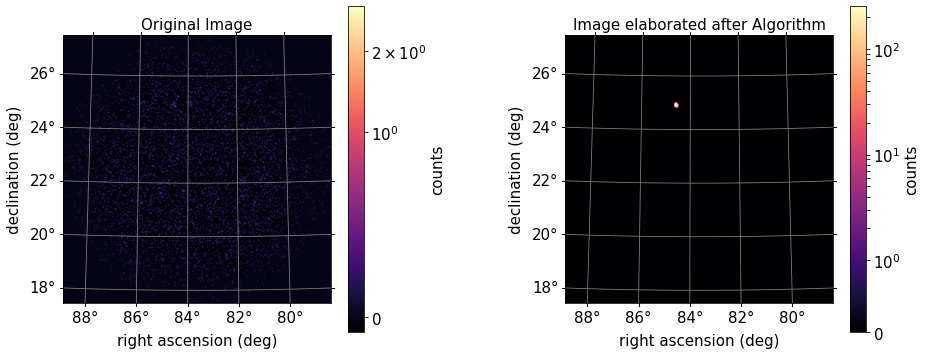


The classification is wrong for the model n. : 322
The true image is : Two or more Sources 
The algorithm predict : One Source          


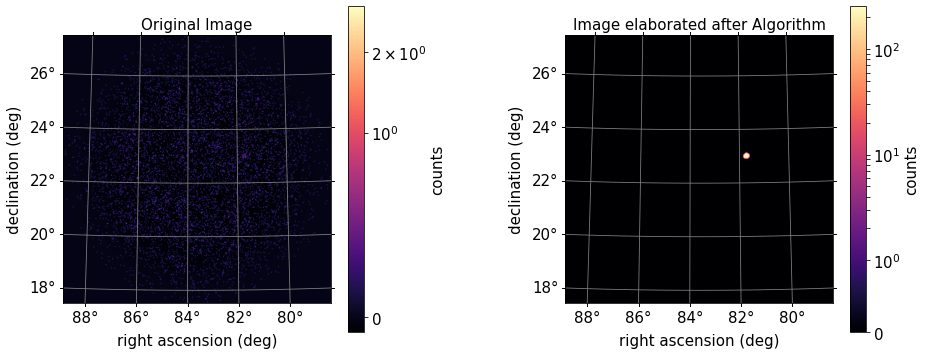


The classification is wrong for the model n. :  41
The true image is : One Source          
The algorithm predict : No Source           


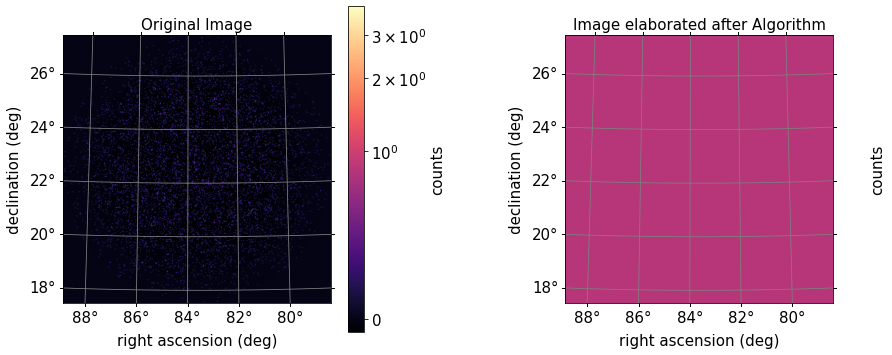


The classification is wrong for the model n. : 353
The true image is : Two or more Sources 
The algorithm predict : One Source          


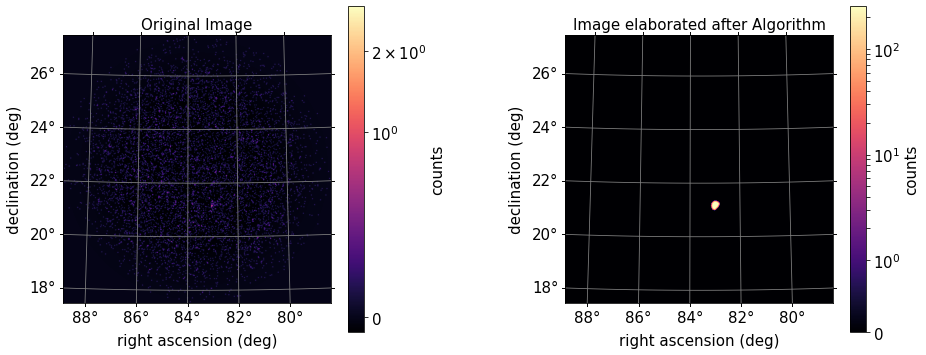


The classification is wrong for the model n. : 300
The true image is : Two or more Sources 
The algorithm predict : One Source          


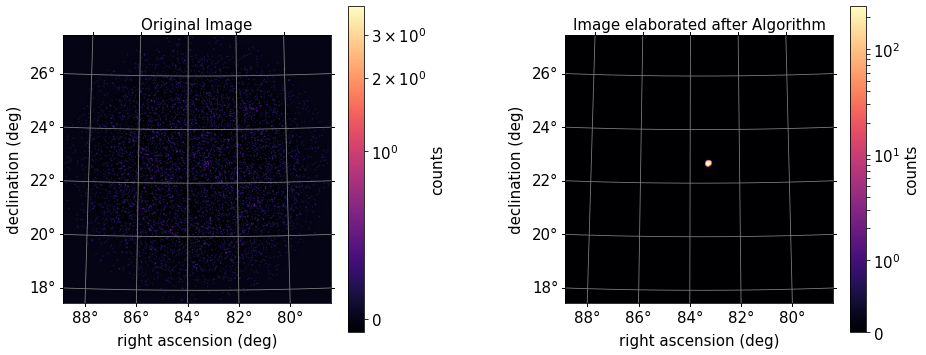


The classification is wrong for the model n. :  78
The true image is : One Source          
The algorithm predict : Two or more Sources 


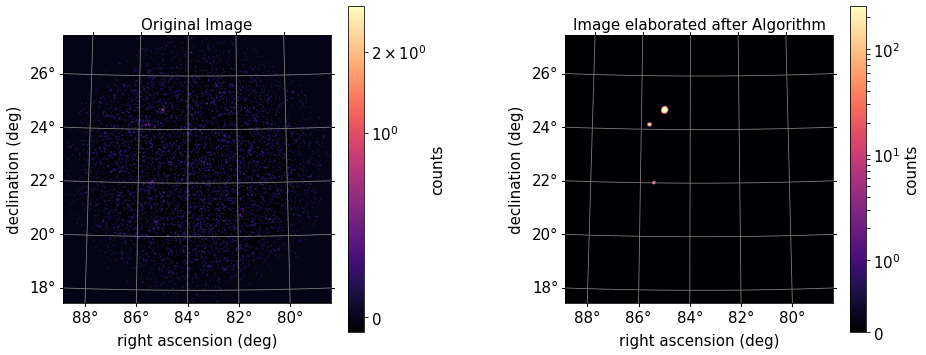


The classification is wrong for the model n. : 290
The true image is : Two or more Sources 
The algorithm predict : One Source          


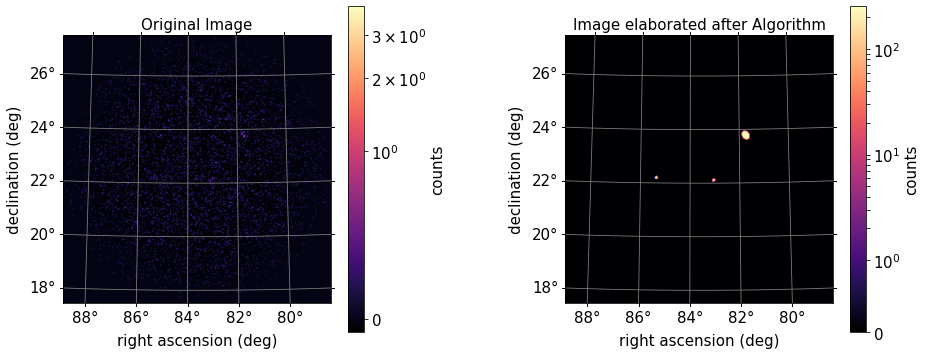

In [16]:
from astropy.wcs import WCS


list_models_test = list(y_test.index) # save the list of the models for the test set
true_class_test = list(y_test) # save the true class for each model for the test set
predicted_class_test = y_test_predicted # save the predicted class for each model for the test set
# these lists have the same index; if at the same index there are differences, it means that the 
# classification is wrong for this model (the number of the model is got by the list_models_test)

error = {
    '0' : 'No Source',
    '1' : 'One Source',
    '2' : 'Two or more Sources'
}
if true_class_test == predicted_class_test:
    print("There are no errors. F1 score is 100%")
else:
    inp = input("Do you want plot the images with the wrong classification? [y/n]  ")
    print()
    if inp == "y":
        # the lists have the same length
        for i in range(0, len(true_class_test)):
            # if the predict is different
            if not predicted_class_test[i] == true_class_test[i]:
                print("The classification is wrong for the model n. :{:4}".format(list_models_test[i]+1))
                print("The true image is : {:20}".format(error.get(str(true_class_test[i]), -1)))
                print("The algorithm predict : {:20}".format(error.get(str(predicted_class_test[i]), -1)))
                
                
                data_of_image = image_concat[y_test.index.values[i]][0].data # get the data values of the wrong image
                w = WCS(image_concat[y_test.index.values[i]][0].header) # get the degrees range of the wrong image
                
                # plot the original image
                fig = plt.figure(figsize=(15,10)) 
                fig.subplots_adjust(wspace=0.5)

                ax = fig.add_subplot(1, 2, 1, projection=wcs)
                img = ax.imshow(data_of_image, norm=SymLogNorm(1), interpolation='gaussian', cmap='magma')
                ax.coords[0].set_format_unit(u.deg)
                ax.coords[1].set_format_unit(u.deg)
                cb = plt.colorbar(img, ax=ax, shrink=0.6)
                #ax.plot(x, y)
                #ax = plt.subplot(projection=wcs)

                # axis for the original image
                ax.tick_params(axis='both', labelsize=15)
                cb.ax.tick_params(labelsize=15) 
                cb.set_label('counts', fontsize=15)
                ax.set_xlabel('right ascension (deg)', fontsize=15)
                ax.set_ylabel('declination (deg)', fontsize=15)
                ax.set_title('Original Image', fontsize=15)
                ax.grid(color='grey', ls='solid')
                
                
                
                # apply gaussian
                gaussian_image = gaussian_filtering(image_concat[y_test.index.values[i]][0].data)

                # apply stretch
                linear_mapping_image = linear_mapping(gaussian_image)

                # apply threshold
                threshold_image = thresholding_image(linear_mapping_image, optimal_median_factor)
                
                
                # plot the predicted image
                ax2 = fig.add_subplot(1, 2, 2, projection=wcs)
                img2 = ax2.imshow(threshold_image, norm=SymLogNorm(1), interpolation='gaussian', cmap='magma')
                ax2.coords[0].set_format_unit(u.deg)
                ax2.coords[1].set_format_unit(u.deg)
                cb = plt.colorbar(img2, ax=ax2, shrink=0.6)

                # axis for the original image
                ax2.tick_params(axis='both', labelsize=15)
                cb.ax.tick_params(labelsize=15) 
                cb.set_label('counts', fontsize=15)
                ax2.set_xlabel('right ascension (deg)', fontsize=15)
                ax2.set_ylabel('declination (deg)', fontsize=15)
                ax2.set_title('Image elaborated after Algorithm', fontsize=15)
                ax2.grid(color='grey', ls='solid')

                plt.show()

                print("==========================================================================================================")
                print()